## Store Item Demand Forecasting 
Source: Kaggle

### Data: 
5 years of store-item sales data, need to predict 3 months of sales for 50 different items at 10 different stores.

### Questions:
* What's the best way to deal with seasonality? 
* Should stores be modeled separately, or can you pool them together? 
* Does deep learning work better than ARIMA? 
* Can either beat xgboost?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [15]:
#Importing train data in a time series dataframe format

train = pd.read_csv('train.csv', parse_dates=['date'], index_col=['date'])
train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [16]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [12]:
train.shape

(913000, 4)

As the count of values in each of the columns is same as total number of rows in the columns, it implies that there aren't any missing value in the train dataset.

In [17]:
#Importing test data in a time series dataframe format

test = pd.read_csv('test.csv', parse_dates=['date'], index_col=['date'])
test.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [18]:
test.describe()

,id,store,item
count,45000.000000,45000.000000,45000.00000
mean,22499.500000,5.500000,25.50000
std,12990.525394,2.872313,14.43103
min,0.000000,1.000000,1.00000
25%,11249.750000,3.000000,13.00000
50%,22499.500000,5.500000,25.50000
75%,33749.250000,8.000000,38.00000
max,44999.000000,10.000000,50.00000


In [19]:
test.shape  #no missing values in test data as well

(45000, 3)

In [23]:
train.store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [24]:
train.item.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

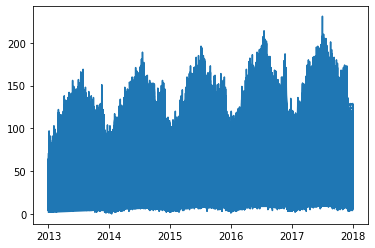

In [22]:
plt.plot(train['sales'])
plt.show()

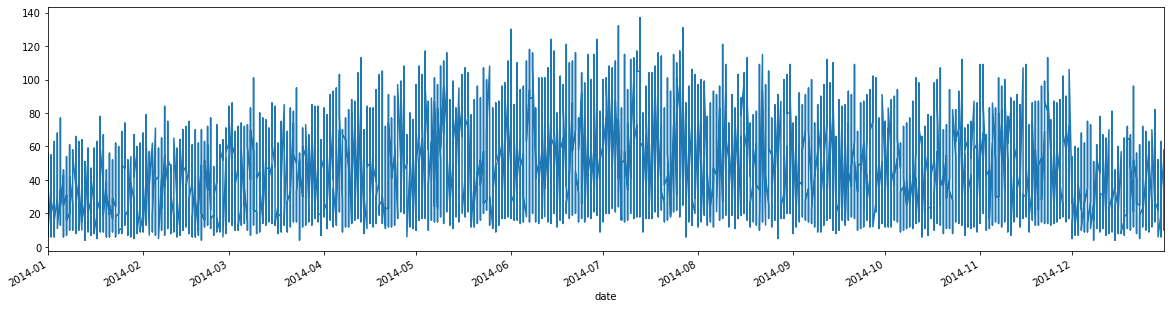

In [41]:
train.loc[(train.store == 1) & (train.index.year == 2014)]['sales'].plot(figsize = (20,5))

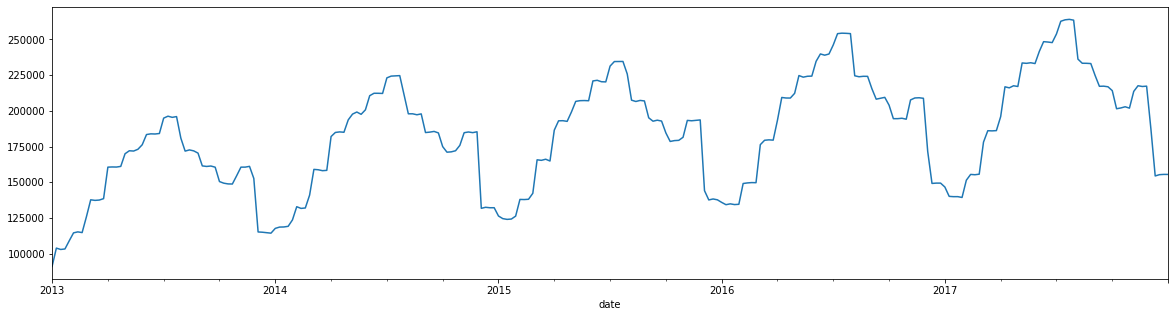

In [30]:
train_wkly_sales = train.sales.resample('W').sum()
train_wkly_sales.plot(figsize = (20,5))

Although it is clear that we have a trend (varying mean) and seasonality in the above series, this visual approach might not always give accurate results. Therefore, it is better to confirm the observations using some statistical tests.

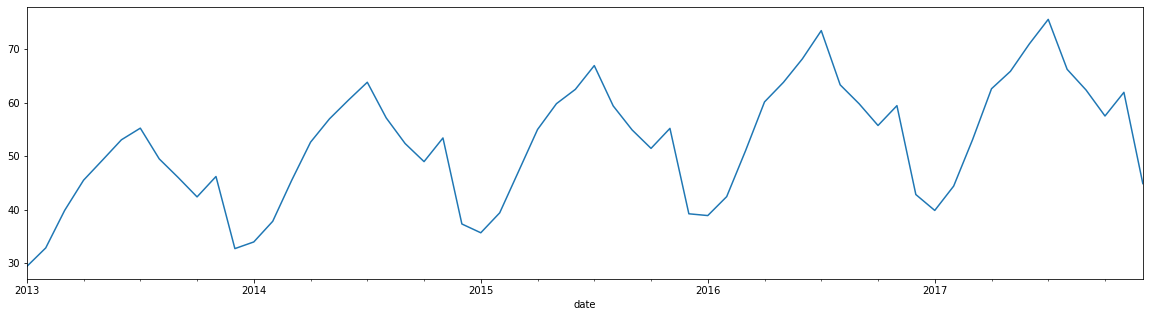

In [91]:
train_monthly_sales = train.sales.resample('MS').mean()
train_monthly_sales.plot(figsize = (20,5))

#### Augmented Dickey-Fuller test or Unit root test
The above time series is a non-stationary plot (has a time-dependent structure). But, we will also validate the same using Augmented Dickey-Fuller (ADF) test or Unit root test.


Null Hypothesis (Ho): The given time series is non-stationary (or has a unit root).

Alternate Hypothesis (Ha): The time series is stationary (or, doesn't have a unit root)

In [93]:
from statsmodels.tsa.stattools import adfuller

X = train_monthly_sales
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -5.382140
p-value: 0.000004
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


As p-value <= 0.05: We reject the null hypothesis (Ho), the data does not have a unit root and is stationary.

However, as the series clearly shows trend and seasonality when checked visually. So, as a next step we will transform (decompose) the series.

A classical decomposition of a time series can be done by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual.

We will use seasonal_decompose in statsmodels to implement this.

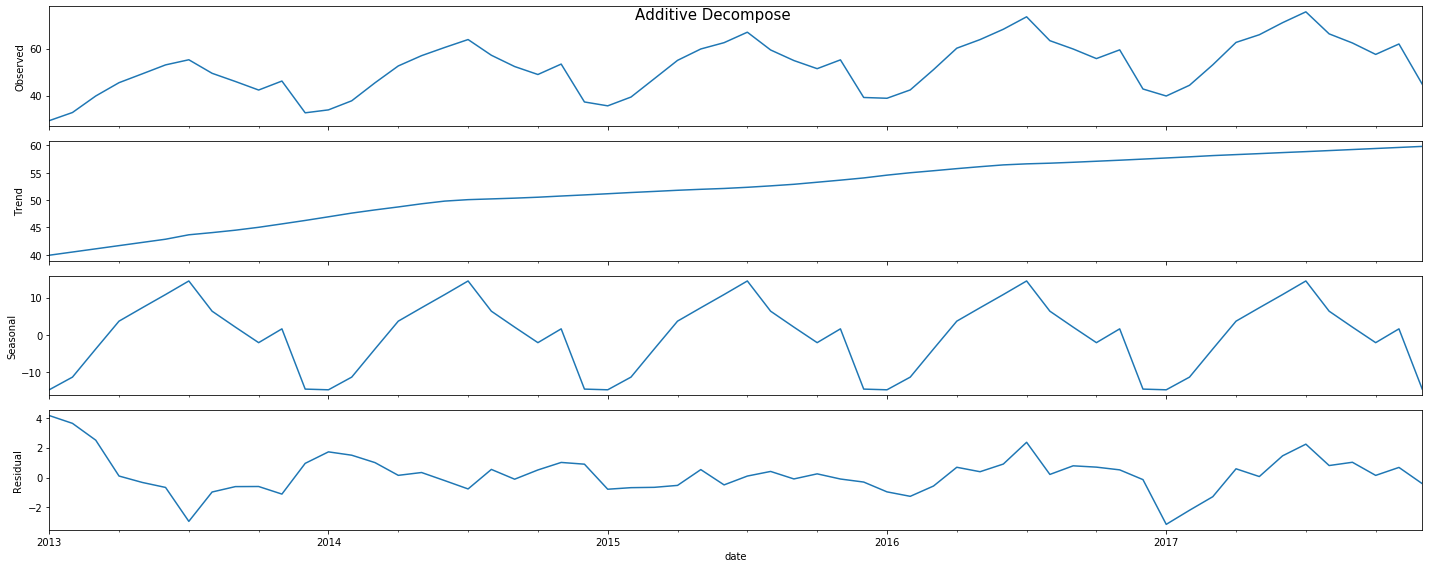

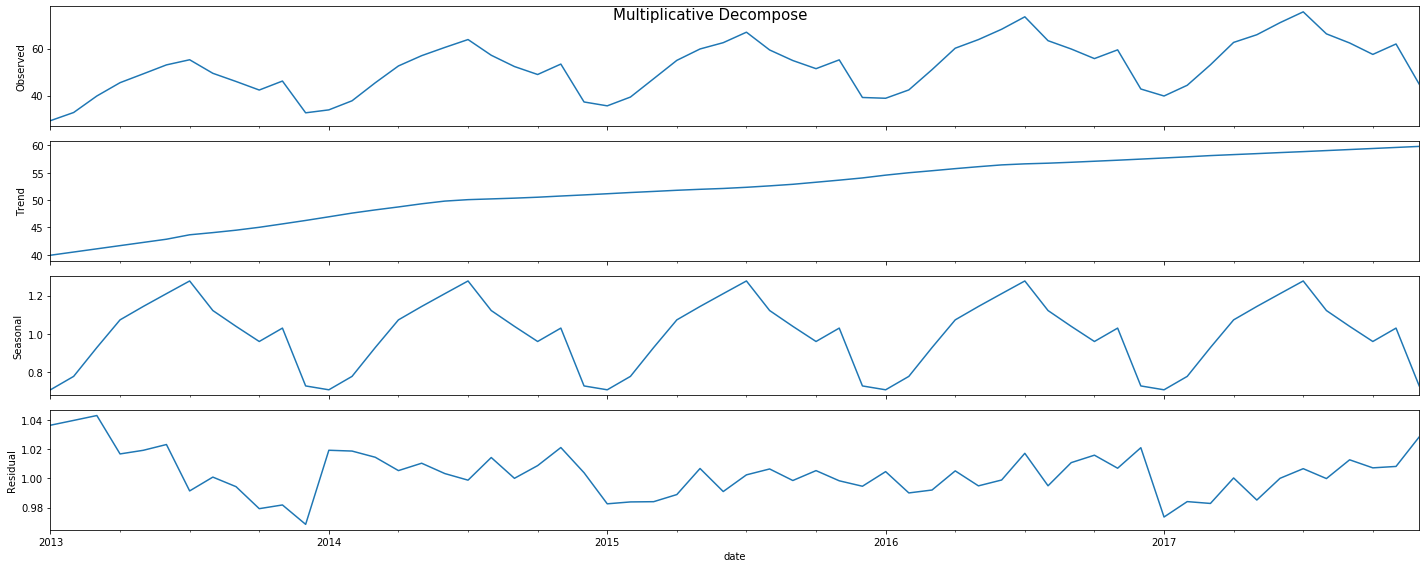

In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition 

#Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series

result_add = seasonal_decompose(train_monthly_sales, model='additive', extrapolate_trend='freq')
#result_add.plot()

# Multiplicative Decomposition 
result_mul = seasonal_decompose(train_monthly_sales, model='multiplicative', extrapolate_trend='freq')
#result_mul.plot()

#Plots
plt.rcParams.update({'figure.figsize': (20,8)})
result_add.plot().suptitle('Additive Decompose', fontsize=15)
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15)
plt.show()

The residuals obtained from multiplicative decomposition look more randomly distributed, so we will continue with multiplicative decomposition

In [96]:
trend = result_mul.trend
seasonal = result_mul.seasonal
residual = result_mul.resid

In [97]:
# Checking stationarity of residuals

result_resid = adfuller(residual)

print('ADF Statistic: %f' % result_resid[0])
print('p-value: %f' % result_resid[1])
print('Critical Values:')
for key, value in result_resid[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.496281
p-value: 0.000200
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


#### ACF and PACF plots

C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


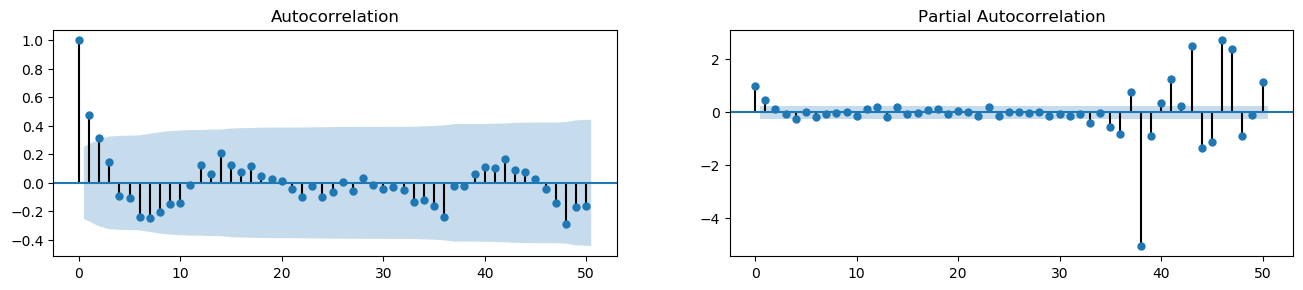

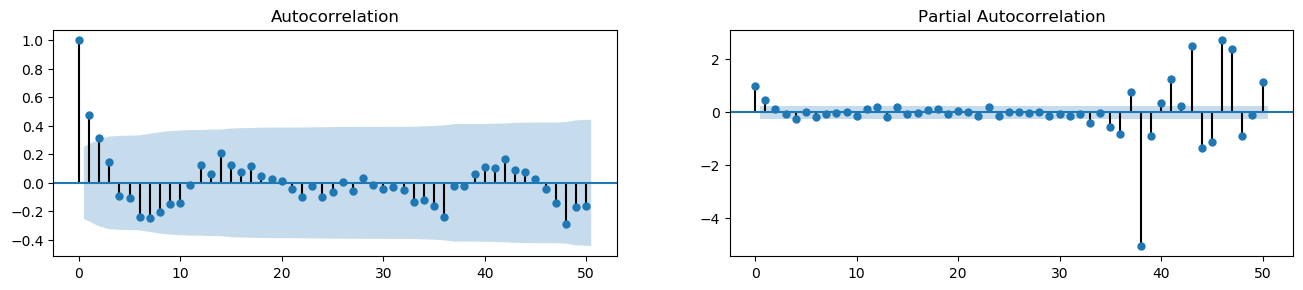

In [98]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(residual.tolist(), lags=50, ax=axes[0])
plot_pacf(residual.tolist(), lags=50, ax=axes[1])



In [99]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [106]:
import statsmodels.api as sm

In [116]:
cnt = 0
aic_val = 9999.0
param_pqd = ''
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_monthly_sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            cnt += 1
            if cnt % 50 :
                print('Current Iter - {}, ARIMA{}x{} 12 - AIC:{}'.format(cnt, param, param_seasonal, results.aic))
                if results.aic < aic_val:
                    aic_val = results.aic
                    param_pqd = str(cnt)+str(param)+str(param_seasonal)
                
        except:
            continue

Current Iter - 1, ARIMA(0, 0, 0)x(0, 0, 0, 12) 12 - AIC:639.3903169231556


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 2, ARIMA(0, 0, 0)x(0, 0, 1, 12) 12 - AIC:515.545063887946
Current Iter - 3, ARIMA(0, 0, 0)x(0, 1, 0, 12) 12 - AIC:272.69049432052384


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 4, ARIMA(0, 0, 0)x(0, 1, 1, 12) 12 - AIC:1226.9538454660483
Current Iter - 5, ARIMA(0, 0, 0)x(0, 2, 0, 12) 12 - AIC:182.93318901930823
Current Iter - 6, ARIMA(0, 0, 0)x(1, 0, 0, 12) 12 - AIC:214.87722464483306
Current Iter - 7, ARIMA(0, 0, 0)x(1, 0, 1, 12) 12 - AIC:194.2026210978883
Current Iter - 8, ARIMA(0, 0, 0)x(1, 1, 0, 12) 12 - AIC:159.12960769429364
Current Iter - 9, ARIMA(0, 0, 0)x(1, 1, 1, 12) 12 - AIC:1173.0606126763435
Current Iter - 10, ARIMA(0, 0, 0)x(1, 2, 0, 12) 12 - AIC:69.40423186123914
Current Iter - 11, ARIMA(0, 0, 0)x(2, 0, 0, 12) 12 - AIC:100.56580160005477
Current Iter - 12, ARIMA(0, 0, 0)x(2, 0, 1, 12) 12 - AIC:96.77925890266438


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 13, ARIMA(0, 0, 0)x(2, 1, 0, 12) 12 - AIC:49.39821838607181


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 14, ARIMA(0, 0, 0)x(2, 1, 1, 12) 12 - AIC:805.9707568503585


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 15, ARIMA(0, 0, 0)x(2, 2, 0, 12) 12 - AIC:28.15258413035429
Current Iter - 16, ARIMA(0, 0, 1)x(0, 0, 0, 12) 12 - AIC:564.702950446029


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 17, ARIMA(0, 0, 1)x(0, 0, 1, 12) 12 - AIC:454.78360922935644
Current Iter - 18, ARIMA(0, 0, 1)x(0, 1, 0, 12) 12 - AIC:216.73070622374343


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 19, ARIMA(0, 0, 1)x(0, 1, 1, 12) 12 - AIC:1373.6233550298457
Current Iter - 20, ARIMA(0, 0, 1)x(0, 2, 0, 12) 12 - AIC:149.6109826420338


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 21, ARIMA(0, 0, 1)x(1, 0, 0, 12) 12 - AIC:217.91149544437175
Current Iter - 22, ARIMA(0, 0, 1)x(1, 0, 1, 12) 12 - AIC:164.46473204767457
Current Iter - 23, ARIMA(0, 0, 1)x(1, 1, 0, 12) 12 - AIC:134.5771866565113


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 24, ARIMA(0, 0, 1)x(1, 1, 1, 12) 12 - AIC:1068.0415474031906
Current Iter - 25, ARIMA(0, 0, 1)x(1, 2, 0, 12) 12 - AIC:70.14181841789464


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 26, ARIMA(0, 0, 1)x(2, 0, 0, 12) 12 - AIC:103.2261793849064


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 27, ARIMA(0, 0, 1)x(2, 0, 1, 12) 12 - AIC:99.61106037207534
Current Iter - 28, ARIMA(0, 0, 1)x(2, 1, 0, 12) 12 - AIC:31.19013006120214


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 29, ARIMA(0, 0, 1)x(2, 1, 1, 12) 12 - AIC:608.8772870980578
Current Iter - 30, ARIMA(0, 0, 1)x(2, 2, 0, 12) 12 - AIC:21.203522124530696
Current Iter - 31, ARIMA(0, 0, 2)x(0, 0, 0, 12) 12 - AIC:497.081310718798


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 32, ARIMA(0, 0, 2)x(0, 0, 1, 12) 12 - AIC:402.1164039561548
Current Iter - 33, ARIMA(0, 0, 2)x(0, 1, 0, 12) 12 - AIC:191.7333592261836
Current Iter - 34, ARIMA(0, 0, 2)x(0, 1, 1, 12) 12 - AIC:1407.038220084388
Current Iter - 35, ARIMA(0, 0, 2)x(0, 2, 0, 12) 12 - AIC:140.1668475416238
Current Iter - 36, ARIMA(0, 0, 2)x(1, 0, 0, 12) 12 - AIC:172.06567228479094


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 37, ARIMA(0, 0, 2)x(1, 0, 1, 12) 12 - AIC:164.5686564944945
Current Iter - 38, ARIMA(0, 0, 2)x(1, 1, 0, 12) 12 - AIC:131.91565568667335
Current Iter - 39, ARIMA(0, 0, 2)x(1, 1, 1, 12) 12 - AIC:1110.3714348128572
Current Iter - 40, ARIMA(0, 0, 2)x(1, 2, 0, 12) 12 - AIC:67.10905341867583


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 41, ARIMA(0, 0, 2)x(2, 0, 0, 12) 12 - AIC:99.50222238476407


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 42, ARIMA(0, 0, 2)x(2, 0, 1, 12) 12 - AIC:94.72823783041471
Current Iter - 43, ARIMA(0, 0, 2)x(2, 1, 0, 12) 12 - AIC:27.896680182089696
Current Iter - 44, ARIMA(0, 0, 2)x(2, 1, 1, 12) 12 - AIC:766.4215522909299
Current Iter - 45, ARIMA(0, 0, 2)x(2, 2, 0, 12) 12 - AIC:18.27696952817189
Current Iter - 46, ARIMA(0, 1, 0)x(0, 0, 0, 12) 12 - AIC:391.16370596945023
Current Iter - 47, ARIMA(0, 1, 0)x(0, 0, 1, 12) 12 - AIC:280.0169338210146
Current Iter - 48, ARIMA(0, 1, 0)x(0, 1, 0, 12) 12 - AIC:141.28001678101307


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 49, ARIMA(0, 1, 0)x(0, 1, 1, 12) 12 - AIC:1409.4153854511073
Current Iter - 51, ARIMA(0, 1, 0)x(1, 0, 0, 12) 12 - AIC:138.60023667081202
Current Iter - 52, ARIMA(0, 1, 0)x(1, 0, 1, 12) 12 - AIC:135.91966797936004
Current Iter - 53, ARIMA(0, 1, 0)x(1, 1, 0, 12) 12 - AIC:101.09291937376749


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 54, ARIMA(0, 1, 0)x(1, 1, 1, 12) 12 - AIC:1632.162774145447
Current Iter - 55, ARIMA(0, 1, 0)x(1, 2, 0, 12) 12 - AIC:75.20416915965566
Current Iter - 56, ARIMA(0, 1, 0)x(2, 0, 0, 12) 12 - AIC:97.7497068608645
Current Iter - 57, ARIMA(0, 1, 0)x(2, 0, 1, 12) 12 - AIC:99.30647070992042
Current Iter - 58, ARIMA(0, 1, 0)x(2, 1, 0, 12) 12 - AIC:71.91438761304005


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 59, ARIMA(0, 1, 0)x(2, 1, 1, 12) 12 - AIC:947.6123122581799
Current Iter - 60, ARIMA(0, 1, 0)x(2, 2, 0, 12) 12 - AIC:37.5367852707807
Current Iter - 61, ARIMA(0, 1, 1)x(0, 0, 0, 12) 12 - AIC:384.96710604512583
Current Iter - 62, ARIMA(0, 1, 1)x(0, 0, 1, 12) 12 - AIC:274.2395771456331
Current Iter - 63, ARIMA(0, 1, 1)x(0, 1, 0, 12) 12 - AIC:140.61103654659357
Current Iter - 64, ARIMA(0, 1, 1)x(0, 1, 1, 12) 12 - AIC:1416.6598746336342
Current Iter - 65, ARIMA(0, 1, 1)x(0, 2, 0, 12) 12 - AIC:126.80753401418691
Current Iter - 66, ARIMA(0, 1, 1)x(1, 0, 0, 12) 12 - AIC:138.93500778838083


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 67, ARIMA(0, 1, 1)x(1, 0, 1, 12) 12 - AIC:137.62167836818463
Current Iter - 68, ARIMA(0, 1, 1)x(1, 1, 0, 12) 12 - AIC:98.18501104848704
Current Iter - 69, ARIMA(0, 1, 1)x(1, 1, 1, 12) 12 - AIC:1428.2685990274288
Current Iter - 70, ARIMA(0, 1, 1)x(1, 2, 0, 12) 12 - AIC:55.31148476340662
Current Iter - 71, ARIMA(0, 1, 1)x(2, 0, 0, 12) 12 - AIC:82.096253922605
Current Iter - 72, ARIMA(0, 1, 1)x(2, 0, 1, 12) 12 - AIC:80.55077045071054
Current Iter - 73, ARIMA(0, 1, 1)x(2, 1, 0, 12) 12 - AIC:52.65769382943911


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 74, ARIMA(0, 1, 1)x(2, 1, 1, 12) 12 - AIC:1117.9852372818923
Current Iter - 75, ARIMA(0, 1, 1)x(2, 2, 0, 12) 12 - AIC:30.21770318536328
Current Iter - 76, ARIMA(0, 1, 2)x(0, 0, 0, 12) 12 - AIC:379.4971142300592
Current Iter - 77, ARIMA(0, 1, 2)x(0, 0, 1, 12) 12 - AIC:270.37895380042045
Current Iter - 78, ARIMA(0, 1, 2)x(0, 1, 0, 12) 12 - AIC:138.44971994970732


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 79, ARIMA(0, 1, 2)x(0, 1, 1, 12) 12 - AIC:1451.2798596455186
Current Iter - 80, ARIMA(0, 1, 2)x(0, 2, 0, 12) 12 - AIC:125.41271824723825
Current Iter - 81, ARIMA(0, 1, 2)x(1, 0, 0, 12) 12 - AIC:140.83543210605686


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 82, ARIMA(0, 1, 2)x(1, 0, 1, 12) 12 - AIC:136.256070765515
Current Iter - 83, ARIMA(0, 1, 2)x(1, 1, 0, 12) 12 - AIC:99.15151226794525


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 84, ARIMA(0, 1, 2)x(1, 1, 1, 12) 12 - AIC:1462.5973665797094
Current Iter - 85, ARIMA(0, 1, 2)x(1, 2, 0, 12) 12 - AIC:46.86624009893294
Current Iter - 86, ARIMA(0, 1, 2)x(2, 0, 0, 12) 12 - AIC:64.68355039363038


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 87, ARIMA(0, 1, 2)x(2, 0, 1, 12) 12 - AIC:67.42330201029134
Current Iter - 88, ARIMA(0, 1, 2)x(2, 1, 0, 12) 12 - AIC:39.763756081772456


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 89, ARIMA(0, 1, 2)x(2, 1, 1, 12) 12 - AIC:968.8877210028819
Current Iter - 90, ARIMA(0, 1, 2)x(2, 2, 0, 12) 12 - AIC:28.56172648846642
Current Iter - 91, ARIMA(0, 2, 0)x(0, 0, 0, 12) 12 - AIC:409.9633450626805
Current Iter - 92, ARIMA(0, 2, 0)x(0, 0, 1, 12) 12 - AIC:294.0410142776984
Current Iter - 93, ARIMA(0, 2, 0)x(0, 1, 0, 12) 12 - AIC:173.57990884678415


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 94, ARIMA(0, 2, 0)x(0, 1, 1, 12) 12 - AIC:1175.4197187567395
Current Iter - 95, ARIMA(0, 2, 0)x(0, 2, 0, 12) 12 - AIC:152.3477433320057


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 96, ARIMA(0, 2, 0)x(1, 0, 0, 12) 12 - AIC:175.79994679513374
Current Iter - 97, ARIMA(0, 2, 0)x(1, 0, 1, 12) 12 - AIC:174.30174890695798
Current Iter - 98, ARIMA(0, 2, 0)x(1, 1, 0, 12) 12 - AIC:133.39278099026217


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 99, ARIMA(0, 2, 0)x(1, 1, 1, 12) 12 - AIC:732.7655338253908
Current Iter - 101, ARIMA(0, 2, 0)x(2, 0, 0, 12) 12 - AIC:134.18760698119482
Current Iter - 102, ARIMA(0, 2, 0)x(2, 0, 1, 12) 12 - AIC:135.87491382348256
Current Iter - 103, ARIMA(0, 2, 0)x(2, 1, 0, 12) 12 - AIC:94.78896067248732


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 104, ARIMA(0, 2, 0)x(2, 1, 1, 12) 12 - AIC:752.0653531057333
Current Iter - 105, ARIMA(0, 2, 0)x(2, 2, 0, 12) 12 - AIC:45.72981461653562
Current Iter - 106, ARIMA(0, 2, 1)x(0, 0, 0, 12) 12 - AIC:384.7192729612003
Current Iter - 107, ARIMA(0, 2, 1)x(0, 0, 1, 12) 12 - AIC:273.7991740970329
Current Iter - 108, ARIMA(0, 2, 1)x(0, 1, 0, 12) 12 - AIC:141.4022520877811


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 109, ARIMA(0, 2, 1)x(0, 1, 1, 12) 12 - AIC:1278.8100184913367
Current Iter - 110, ARIMA(0, 2, 1)x(0, 2, 0, 12) 12 - AIC:127.3404996651985
Current Iter - 111, ARIMA(0, 2, 1)x(1, 0, 0, 12) 12 - AIC:142.3482390839727


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 112, ARIMA(0, 2, 1)x(1, 0, 1, 12) 12 - AIC:139.23125143121118
Current Iter - 113, ARIMA(0, 2, 1)x(1, 1, 0, 12) 12 - AIC:104.88137079593186


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 114, ARIMA(0, 2, 1)x(1, 1, 1, 12) 12 - AIC:1283.6486176293624
Current Iter - 115, ARIMA(0, 2, 1)x(1, 2, 0, 12) 12 - AIC:78.22156636310022
Current Iter - 116, ARIMA(0, 2, 1)x(2, 0, 0, 12) 12 - AIC:101.66087309046821
Current Iter - 117, ARIMA(0, 2, 1)x(2, 0, 1, 12) 12 - AIC:102.84085595434098
Current Iter - 118, ARIMA(0, 2, 1)x(2, 1, 0, 12) 12 - AIC:75.16175393673602


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 119, ARIMA(0, 2, 1)x(2, 1, 1, 12) 12 - AIC:939.8346943254053
Current Iter - 120, ARIMA(0, 2, 1)x(2, 2, 0, 12) 12 - AIC:39.952149447203695
Current Iter - 121, ARIMA(0, 2, 2)x(0, 0, 0, 12) 12 - AIC:379.2976443370531
Current Iter - 122, ARIMA(0, 2, 2)x(0, 0, 1, 12) 12 - AIC:269.39710776832896
Current Iter - 123, ARIMA(0, 2, 2)x(0, 1, 0, 12) 12 - AIC:140.7882448636783


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 124, ARIMA(0, 2, 2)x(0, 1, 1, 12) 12 - AIC:1192.9301125036686
Current Iter - 125, ARIMA(0, 2, 2)x(0, 2, 0, 12) 12 - AIC:125.66523550302084
Current Iter - 126, ARIMA(0, 2, 2)x(1, 0, 0, 12) 12 - AIC:142.92990774670074


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 127, ARIMA(0, 2, 2)x(1, 0, 1, 12) 12 - AIC:138.0572252497978
Current Iter - 128, ARIMA(0, 2, 2)x(1, 1, 0, 12) 12 - AIC:102.85587700486883


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 129, ARIMA(0, 2, 2)x(1, 1, 1, 12) 12 - AIC:1197.6957211845727
Current Iter - 130, ARIMA(0, 2, 2)x(1, 2, 0, 12) 12 - AIC:62.11780826557303
Current Iter - 131, ARIMA(0, 2, 2)x(2, 0, 0, 12) 12 - AIC:87.37528761615181


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 132, ARIMA(0, 2, 2)x(2, 0, 1, 12) 12 - AIC:84.16969555305255
Current Iter - 133, ARIMA(0, 2, 2)x(2, 1, 0, 12) 12 - AIC:59.50130431253639


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 134, ARIMA(0, 2, 2)x(2, 1, 1, 12) 12 - AIC:907.7052952869645
Current Iter - 135, ARIMA(0, 2, 2)x(2, 2, 0, 12) 12 - AIC:29.887564057794975
Current Iter - 136, ARIMA(1, 0, 0)x(0, 0, 0, 12) 12 - AIC:399.0339765043369
Current Iter - 137, ARIMA(1, 0, 0)x(0, 0, 1, 12) 12 - AIC:322.87355183490666
Current Iter - 138, ARIMA(1, 0, 0)x(0, 1, 0, 12) 12 - AIC:144.16169983552746


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 139, ARIMA(1, 0, 0)x(0, 1, 1, 12) 12 - AIC:1478.4910921321884
Current Iter - 140, ARIMA(1, 0, 0)x(0, 2, 0, 12) 12 - AIC:130.81008371222876
Current Iter - 141, ARIMA(1, 0, 0)x(1, 0, 0, 12) 12 - AIC:137.3742644760068
Current Iter - 142, ARIMA(1, 0, 0)x(1, 0, 1, 12) 12 - AIC:136.19430647648787
Current Iter - 143, ARIMA(1, 0, 0)x(1, 1, 0, 12) 12 - AIC:102.41329405494827


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 144, ARIMA(1, 0, 0)x(1, 1, 1, 12) 12 - AIC:1163.7237303581278
Current Iter - 145, ARIMA(1, 0, 0)x(1, 2, 0, 12) 12 - AIC:67.50428085303011
Current Iter - 146, ARIMA(1, 0, 0)x(2, 0, 0, 12) 12 - AIC:90.33603651844373
Current Iter - 147, ARIMA(1, 0, 0)x(2, 0, 1, 12) 12 - AIC:92.33604741549821


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 148, ARIMA(1, 0, 0)x(2, 1, 0, 12) 12 - AIC:41.721048876432825


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 149, ARIMA(1, 0, 0)x(2, 1, 1, 12) 12 - AIC:649.6339623024517
Current Iter - 151, ARIMA(1, 0, 1)x(0, 0, 0, 12) 12 - AIC:393.5118995581225


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 152, ARIMA(1, 0, 1)x(0, 0, 1, 12) 12 - AIC:283.1902570397929
Current Iter - 153, ARIMA(1, 0, 1)x(0, 1, 0, 12) 12 - AIC:143.70107617722687


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 154, ARIMA(1, 0, 1)x(0, 1, 1, 12) 12 - AIC:1246.7080968338453
Current Iter - 155, ARIMA(1, 0, 1)x(0, 2, 0, 12) 12 - AIC:129.6360680828803
Current Iter - 156, ARIMA(1, 0, 1)x(1, 0, 0, 12) 12 - AIC:138.3950220081904


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 157, ARIMA(1, 0, 1)x(1, 0, 1, 12) 12 - AIC:138.98728318711323
Current Iter - 158, ARIMA(1, 0, 1)x(1, 1, 0, 12) 12 - AIC:99.98958117647834


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 159, ARIMA(1, 0, 1)x(1, 1, 1, 12) 12 - AIC:940.9896291742921
Current Iter - 160, ARIMA(1, 0, 1)x(1, 2, 0, 12) 12 - AIC:57.15811381390022
Current Iter - 161, ARIMA(1, 0, 1)x(2, 0, 0, 12) 12 - AIC:82.77866896693416


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 162, ARIMA(1, 0, 1)x(2, 0, 1, 12) 12 - AIC:81.3787405967813
Current Iter - 163, ARIMA(1, 0, 1)x(2, 1, 0, 12) 12 - AIC:29.69327440324925


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 164, ARIMA(1, 0, 1)x(2, 1, 1, 12) 12 - AIC:597.8477430947781
Current Iter - 165, ARIMA(1, 0, 1)x(2, 2, 0, 12) 12 - AIC:18.039424371533855
Current Iter - 166, ARIMA(1, 0, 2)x(0, 0, 0, 12) 12 - AIC:387.508420289117
Current Iter - 167, ARIMA(1, 0, 2)x(0, 0, 1, 12) 12 - AIC:311.84174896644794
Current Iter - 168, ARIMA(1, 0, 2)x(0, 1, 0, 12) 12 - AIC:142.9901567315977


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 169, ARIMA(1, 0, 2)x(0, 1, 1, 12) 12 - AIC:1474.0180034418295
Current Iter - 170, ARIMA(1, 0, 2)x(0, 2, 0, 12) 12 - AIC:128.38595245534003
Current Iter - 171, ARIMA(1, 0, 2)x(1, 0, 0, 12) 12 - AIC:140.2729151769996
Current Iter - 172, ARIMA(1, 0, 2)x(1, 0, 1, 12) 12 - AIC:133.07232176612916
Current Iter - 173, ARIMA(1, 0, 2)x(1, 1, 0, 12) 12 - AIC:100.85600052367258


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 174, ARIMA(1, 0, 2)x(1, 1, 1, 12) 12 - AIC:1177.351219819071
Current Iter - 175, ARIMA(1, 0, 2)x(1, 2, 0, 12) 12 - AIC:48.751188213997835
Current Iter - 176, ARIMA(1, 0, 2)x(2, 0, 0, 12) 12 - AIC:65.72836436191432
Current Iter - 177, ARIMA(1, 0, 2)x(2, 0, 1, 12) 12 - AIC:67.72141229980699


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 178, ARIMA(1, 0, 2)x(2, 1, 0, 12) 12 - AIC:27.95632084444478


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 179, ARIMA(1, 0, 2)x(2, 1, 1, 12) 12 - AIC:782.2762631911156


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 180, ARIMA(1, 0, 2)x(2, 2, 0, 12) 12 - AIC:17.73062886211163
Current Iter - 181, ARIMA(1, 1, 0)x(0, 0, 0, 12) 12 - AIC:391.06416140520935
Current Iter - 182, ARIMA(1, 1, 0)x(0, 0, 1, 12) 12 - AIC:280.09009468821466
Current Iter - 183, ARIMA(1, 1, 0)x(0, 1, 0, 12) 12 - AIC:143.0318404147252


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 184, ARIMA(1, 1, 0)x(0, 1, 1, 12) 12 - AIC:1328.630422045297
Current Iter - 185, ARIMA(1, 1, 0)x(0, 2, 0, 12) 12 - AIC:129.79841558752594
Current Iter - 186, ARIMA(1, 1, 0)x(1, 0, 0, 12) 12 - AIC:137.12786860817636


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 187, ARIMA(1, 1, 0)x(1, 0, 1, 12) 12 - AIC:139.5597133743865
Current Iter - 188, ARIMA(1, 1, 0)x(1, 1, 0, 12) 12 - AIC:96.29950378515731


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 189, ARIMA(1, 1, 0)x(1, 1, 1, 12) 12 - AIC:1340.5303203350593
Current Iter - 190, ARIMA(1, 1, 0)x(1, 2, 0, 12) 12 - AIC:63.611885454111736
Current Iter - 191, ARIMA(1, 1, 0)x(2, 0, 0, 12) 12 - AIC:83.02501602524667
Current Iter - 192, ARIMA(1, 1, 0)x(2, 0, 1, 12) 12 - AIC:83.79982934367939
Current Iter - 193, ARIMA(1, 1, 0)x(2, 1, 0, 12) 12 - AIC:60.48106827175378


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 194, ARIMA(1, 1, 0)x(2, 1, 1, 12) 12 - AIC:799.0056106785441
Current Iter - 195, ARIMA(1, 1, 0)x(2, 2, 0, 12) 12 - AIC:30.94793028973987
Current Iter - 196, ARIMA(1, 1, 1)x(0, 0, 0, 12) 12 - AIC:386.1906788782789
Current Iter - 197, ARIMA(1, 1, 1)x(0, 0, 1, 12) 12 - AIC:276.1177012157655
Current Iter - 198, ARIMA(1, 1, 1)x(0, 1, 0, 12) 12 - AIC:142.00454208716215


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 199, ARIMA(1, 1, 1)x(0, 1, 1, 12) 12 - AIC:1341.8313376181293
Current Iter - 201, ARIMA(1, 1, 1)x(1, 0, 0, 12) 12 - AIC:139.01319908842524


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 202, ARIMA(1, 1, 1)x(1, 0, 1, 12) 12 - AIC:139.77951328276623
Current Iter - 203, ARIMA(1, 1, 1)x(1, 1, 0, 12) 12 - AIC:98.0057702800064


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 204, ARIMA(1, 1, 1)x(1, 1, 1, 12) 12 - AIC:1353.4402141099347
Current Iter - 205, ARIMA(1, 1, 1)x(1, 2, 0, 12) 12 - AIC:49.435328151547274
Current Iter - 206, ARIMA(1, 1, 1)x(2, 0, 0, 12) 12 - AIC:77.83533458480404
Current Iter - 207, ARIMA(1, 1, 1)x(2, 0, 1, 12) 12 - AIC:76.96410657215442
Current Iter - 208, ARIMA(1, 1, 1)x(2, 1, 0, 12) 12 - AIC:45.474656464594304


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 209, ARIMA(1, 1, 1)x(2, 1, 1, 12) 12 - AIC:1044.6254928655103
Current Iter - 210, ARIMA(1, 1, 1)x(2, 2, 0, 12) 12 - AIC:26.56429159218588
Current Iter - 211, ARIMA(1, 1, 2)x(0, 0, 0, 12) 12 - AIC:373.98179443400875
Current Iter - 212, ARIMA(1, 1, 2)x(0, 0, 1, 12) 12 - AIC:270.6623011333513
Current Iter - 213, ARIMA(1, 1, 2)x(0, 1, 0, 12) 12 - AIC:138.90886393704858


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 214, ARIMA(1, 1, 2)x(0, 1, 1, 12) 12 - AIC:1530.3691929328143
Current Iter - 215, ARIMA(1, 1, 2)x(0, 2, 0, 12) 12 - AIC:125.73705192979946
Current Iter - 216, ARIMA(1, 1, 2)x(1, 0, 0, 12) 12 - AIC:140.4379345647738


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 217, ARIMA(1, 1, 2)x(1, 0, 1, 12) 12 - AIC:137.75761237289902
Current Iter - 218, ARIMA(1, 1, 2)x(1, 1, 0, 12) 12 - AIC:98.18689061421631


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 219, ARIMA(1, 1, 2)x(1, 1, 1, 12) 12 - AIC:1541.6867408114626
Current Iter - 220, ARIMA(1, 1, 2)x(1, 2, 0, 12) 12 - AIC:46.64156705715012
Current Iter - 221, ARIMA(1, 1, 2)x(2, 0, 0, 12) 12 - AIC:66.14837732128316


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 222, ARIMA(1, 1, 2)x(2, 0, 1, 12) 12 - AIC:69.89168209803805


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 223, ARIMA(1, 1, 2)x(2, 1, 0, 12) 12 - AIC:47.922403597371215


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 224, ARIMA(1, 1, 2)x(2, 1, 1, 12) 12 - AIC:945.9997603320055
Current Iter - 225, ARIMA(1, 1, 2)x(2, 2, 0, 12) 12 - AIC:27.256827052492394
Current Iter - 226, ARIMA(1, 2, 0)x(0, 0, 0, 12) 12 - AIC:398.7159569562058
Current Iter - 227, ARIMA(1, 2, 0)x(0, 0, 1, 12) 12 - AIC:284.53287238890005
Current Iter - 228, ARIMA(1, 2, 0)x(0, 1, 0, 12) 12 - AIC:162.38997656482388


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 229, ARIMA(1, 2, 0)x(0, 1, 1, 12) 12 - AIC:1230.684267338694
Current Iter - 230, ARIMA(1, 2, 0)x(0, 2, 0, 12) 12 - AIC:145.2530674528963
Current Iter - 231, ARIMA(1, 2, 0)x(1, 0, 0, 12) 12 - AIC:158.95510457635865


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 232, ARIMA(1, 2, 0)x(1, 0, 1, 12) 12 - AIC:161.31298831297576
Current Iter - 233, ARIMA(1, 2, 0)x(1, 1, 0, 12) 12 - AIC:115.18678383287812


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 234, ARIMA(1, 2, 0)x(1, 1, 1, 12) 12 - AIC:1235.6102331593013
Current Iter - 235, ARIMA(1, 2, 0)x(1, 2, 0, 12) 12 - AIC:84.35179925823995
Current Iter - 236, ARIMA(1, 2, 0)x(2, 0, 0, 12) 12 - AIC:112.98985261790857
Current Iter - 237, ARIMA(1, 2, 0)x(2, 0, 1, 12) 12 - AIC:114.80917865516919
Current Iter - 238, ARIMA(1, 2, 0)x(2, 1, 0, 12) 12 - AIC:80.49381713916046


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 239, ARIMA(1, 2, 0)x(2, 1, 1, 12) 12 - AIC:829.7429137095382
Current Iter - 240, ARIMA(1, 2, 0)x(2, 2, 0, 12) 12 - AIC:38.519604908177826
Current Iter - 241, ARIMA(1, 2, 1)x(0, 0, 0, 12) 12 - AIC:384.9911183703447
Current Iter - 242, ARIMA(1, 2, 1)x(0, 0, 1, 12) 12 - AIC:274.02441722140964
Current Iter - 243, ARIMA(1, 2, 1)x(0, 1, 0, 12) 12 - AIC:143.19260554186772


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 244, ARIMA(1, 2, 1)x(0, 1, 1, 12) 12 - AIC:1262.7389484237642
Current Iter - 245, ARIMA(1, 2, 1)x(0, 2, 0, 12) 12 - AIC:128.91188660156763
Current Iter - 246, ARIMA(1, 2, 1)x(1, 0, 0, 12) 12 - AIC:140.69564861486003


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 247, ARIMA(1, 2, 1)x(1, 0, 1, 12) 12 - AIC:141.37609869764933
Current Iter - 248, ARIMA(1, 2, 1)x(1, 1, 0, 12) 12 - AIC:99.73137019780101


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 249, ARIMA(1, 2, 1)x(1, 1, 1, 12) 12 - AIC:1267.572522042984
Current Iter - 251, ARIMA(1, 2, 1)x(2, 0, 0, 12) 12 - AIC:87.20017104236315
Current Iter - 252, ARIMA(1, 2, 1)x(2, 0, 1, 12) 12 - AIC:87.5452074411179
Current Iter - 253, ARIMA(1, 2, 1)x(2, 1, 0, 12) 12 - AIC:63.82272853794385


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 254, ARIMA(1, 2, 1)x(2, 1, 1, 12) 12 - AIC:887.7069827906515
Current Iter - 255, ARIMA(1, 2, 1)x(2, 2, 0, 12) 12 - AIC:31.746554478287386
Current Iter - 256, ARIMA(1, 2, 2)x(0, 0, 0, 12) 12 - AIC:378.71013938621024
Current Iter - 257, ARIMA(1, 2, 2)x(0, 0, 1, 12) 12 - AIC:269.5246889566638
Current Iter - 258, ARIMA(1, 2, 2)x(0, 1, 0, 12) 12 - AIC:141.6369000996563


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 259, ARIMA(1, 2, 2)x(0, 1, 1, 12) 12 - AIC:959.2441923140065
Current Iter - 260, ARIMA(1, 2, 2)x(0, 2, 0, 12) 12 - AIC:127.51777207070816
Current Iter - 261, ARIMA(1, 2, 2)x(1, 0, 0, 12) 12 - AIC:142.69507603424154
Current Iter - 262, ARIMA(1, 2, 2)x(1, 0, 1, 12) 12 - AIC:135.5111530433999
Current Iter - 263, ARIMA(1, 2, 2)x(1, 1, 0, 12) 12 - AIC:101.56038512460911


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 264, ARIMA(1, 2, 2)x(1, 1, 1, 12) 12 - AIC:963.9936407809306
Current Iter - 265, ARIMA(1, 2, 2)x(1, 2, 0, 12) 12 - AIC:56.39876057515254
Current Iter - 266, ARIMA(1, 2, 2)x(2, 0, 0, 12) 12 - AIC:74.77143139603689


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 267, ARIMA(1, 2, 2)x(2, 0, 1, 12) 12 - AIC:81.1105435417871
Current Iter - 268, ARIMA(1, 2, 2)x(2, 1, 0, 12) 12 - AIC:52.07719200380676


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 269, ARIMA(1, 2, 2)x(2, 1, 1, 12) 12 - AIC:709.323385652271
Current Iter - 270, ARIMA(1, 2, 2)x(2, 2, 0, 12) 12 - AIC:25.95483095856026
Current Iter - 271, ARIMA(2, 0, 0)x(0, 0, 0, 12) 12 - AIC:392.7804750849743
Current Iter - 272, ARIMA(2, 0, 0)x(0, 0, 1, 12) 12 - AIC:322.8026699126429
Current Iter - 273, ARIMA(2, 0, 0)x(0, 1, 0, 12) 12 - AIC:143.71908294537545


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 274, ARIMA(2, 0, 0)x(0, 1, 1, 12) 12 - AIC:1622.494539668208
Current Iter - 275, ARIMA(2, 0, 0)x(0, 2, 0, 12) 12 - AIC:129.67596588659106


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 276, ARIMA(2, 0, 0)x(1, 0, 0, 12) 12 - AIC:136.4222883521588


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 277, ARIMA(2, 0, 0)x(1, 0, 1, 12) 12 - AIC:139.1157626516562
Current Iter - 278, ARIMA(2, 0, 0)x(1, 1, 0, 12) 12 - AIC:98.06397811224797


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 279, ARIMA(2, 0, 0)x(1, 1, 1, 12) 12 - AIC:1086.056419391741
Current Iter - 280, ARIMA(2, 0, 0)x(1, 2, 0, 12) 12 - AIC:62.75621541938657
Current Iter - 281, ARIMA(2, 0, 0)x(2, 0, 0, 12) 12 - AIC:82.17495029371216
Current Iter - 282, ARIMA(2, 0, 0)x(2, 0, 1, 12) 12 - AIC:83.24964347467495
Current Iter - 283, ARIMA(2, 0, 0)x(2, 1, 0, 12) 12 - AIC:29.375707086593994


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 284, ARIMA(2, 0, 0)x(2, 1, 1, 12) 12 - AIC:696.4354013131251
Current Iter - 285, ARIMA(2, 0, 0)x(2, 2, 0, 12) 12 - AIC:19.386601212249126
Current Iter - 286, ARIMA(2, 0, 1)x(0, 0, 0, 12) 12 - AIC:394.09843145295787
Current Iter - 287, ARIMA(2, 0, 1)x(0, 0, 1, 12) 12 - AIC:318.10349631203866
Current Iter - 288, ARIMA(2, 0, 1)x(0, 1, 0, 12) 12 - AIC:143.33226140328406


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 289, ARIMA(2, 0, 1)x(0, 1, 1, 12) 12 - AIC:1360.5558975347112
Current Iter - 290, ARIMA(2, 0, 1)x(0, 2, 0, 12) 12 - AIC:127.73736288585918
Current Iter - 291, ARIMA(2, 0, 1)x(1, 0, 0, 12) 12 - AIC:138.30834355830413


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 292, ARIMA(2, 0, 1)x(1, 0, 1, 12) 12 - AIC:141.12371037587965
Current Iter - 293, ARIMA(2, 0, 1)x(1, 1, 0, 12) 12 - AIC:101.3246993447438


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 294, ARIMA(2, 0, 1)x(1, 1, 1, 12) 12 - AIC:1054.8416207625849
Current Iter - 295, ARIMA(2, 0, 1)x(1, 2, 0, 12) 12 - AIC:51.40871537517262
Current Iter - 296, ARIMA(2, 0, 1)x(2, 0, 0, 12) 12 - AIC:78.96736795987083


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 297, ARIMA(2, 0, 1)x(2, 0, 1, 12) 12 - AIC:78.058114264928


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 298, ARIMA(2, 0, 1)x(2, 1, 0, 12) 12 - AIC:29.770102521084787


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 299, ARIMA(2, 0, 1)x(2, 1, 1, 12) 12 - AIC:646.7552255693239
Current Iter - 301, ARIMA(2, 0, 2)x(0, 0, 0, 12) 12 - AIC:388.825068831603


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 302, ARIMA(2, 0, 2)x(0, 0, 1, 12) 12 - AIC:312.3144911340231
Current Iter - 303, ARIMA(2, 0, 2)x(0, 1, 0, 12) 12 - AIC:143.46937048991063


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 304, ARIMA(2, 0, 2)x(0, 1, 1, 12) 12 - AIC:1244.250903321637
Current Iter - 305, ARIMA(2, 0, 2)x(0, 2, 0, 12) 12 - AIC:128.7565900407072
Current Iter - 306, ARIMA(2, 0, 2)x(1, 0, 0, 12) 12 - AIC:139.91431113028284
Current Iter - 307, ARIMA(2, 0, 2)x(1, 0, 1, 12) 12 - AIC:136.28203041352353
Current Iter - 308, ARIMA(2, 0, 2)x(1, 1, 0, 12) 12 - AIC:100.37473661981473


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 309, ARIMA(2, 0, 2)x(1, 1, 1, 12) 12 - AIC:947.5837492394745
Current Iter - 310, ARIMA(2, 0, 2)x(1, 2, 0, 12) 12 - AIC:48.527119965986834


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 311, ARIMA(2, 0, 2)x(2, 0, 0, 12) 12 - AIC:67.32058074265832


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 312, ARIMA(2, 0, 2)x(2, 0, 1, 12) 12 - AIC:69.42767292176183


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 313, ARIMA(2, 0, 2)x(2, 1, 0, 12) 12 - AIC:28.58391337180839


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 314, ARIMA(2, 0, 2)x(2, 1, 1, 12) 12 - AIC:596.3612319258275


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 315, ARIMA(2, 0, 2)x(2, 2, 0, 12) 12 - AIC:17.459959634135732
Current Iter - 316, ARIMA(2, 1, 0)x(0, 0, 0, 12) 12 - AIC:385.74984618995296
Current Iter - 317, ARIMA(2, 1, 0)x(0, 0, 1, 12) 12 - AIC:281.4354632277268
Current Iter - 318, ARIMA(2, 1, 0)x(0, 1, 0, 12) 12 - AIC:142.4043808410519


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 319, ARIMA(2, 1, 0)x(0, 1, 1, 12) 12 - AIC:1639.5470435439051
Current Iter - 320, ARIMA(2, 1, 0)x(0, 2, 0, 12) 12 - AIC:128.01686775243422
Current Iter - 321, ARIMA(2, 1, 0)x(1, 0, 0, 12) 12 - AIC:136.79070147958635


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 322, ARIMA(2, 1, 0)x(1, 0, 1, 12) 12 - AIC:139.30512273980452
Current Iter - 323, ARIMA(2, 1, 0)x(1, 1, 0, 12) 12 - AIC:95.92836073202945
Current Iter - 324, ARIMA(2, 1, 0)x(1, 1, 1, 12) 12 - AIC:1419.1208749088034
Current Iter - 325, ARIMA(2, 1, 0)x(1, 2, 0, 12) 12 - AIC:45.30880407736369
Current Iter - 326, ARIMA(2, 1, 0)x(2, 0, 0, 12) 12 - AIC:67.17625270637808
Current Iter - 327, ARIMA(2, 1, 0)x(2, 0, 1, 12) 12 - AIC:66.85801627885832
Current Iter - 328, ARIMA(2, 1, 0)x(2, 1, 0, 12) 12 - AIC:41.917950534734715


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 329, ARIMA(2, 1, 0)x(2, 1, 1, 12) 12 - AIC:902.1196628264046
Current Iter - 330, ARIMA(2, 1, 0)x(2, 2, 0, 12) 12 - AIC:24.429306551675314
Current Iter - 331, ARIMA(2, 1, 1)x(0, 0, 0, 12) 12 - AIC:381.36362850846706
Current Iter - 332, ARIMA(2, 1, 1)x(0, 0, 1, 12) 12 - AIC:271.9496232643638
Current Iter - 333, ARIMA(2, 1, 1)x(0, 1, 0, 12) 12 - AIC:142.195400283124


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 334, ARIMA(2, 1, 1)x(0, 1, 1, 12) 12 - AIC:2282.9941970392674
Current Iter - 335, ARIMA(2, 1, 1)x(0, 2, 0, 12) 12 - AIC:127.3732866780858
Current Iter - 336, ARIMA(2, 1, 1)x(1, 0, 0, 12) 12 - AIC:137.364487385047


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 337, ARIMA(2, 1, 1)x(1, 0, 1, 12) 12 - AIC:140.411327395601
Current Iter - 338, ARIMA(2, 1, 1)x(1, 1, 0, 12) 12 - AIC:93.99117583858


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 339, ARIMA(2, 1, 1)x(1, 1, 1, 12) 12 - AIC:nan


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 340, ARIMA(2, 1, 1)x(1, 2, 0, 12) 12 - AIC:47.58411970851947


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 341, ARIMA(2, 1, 1)x(2, 0, 0, 12) 12 - AIC:69.55549000606621


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 342, ARIMA(2, 1, 1)x(2, 0, 1, 12) 12 - AIC:69.93818689361734


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 343, ARIMA(2, 1, 1)x(2, 1, 0, 12) 12 - AIC:44.31643194116325


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 344, ARIMA(2, 1, 1)x(2, 1, 1, 12) 12 - AIC:nan
Current Iter - 345, ARIMA(2, 1, 1)x(2, 2, 0, 12) 12 - AIC:29.1353020720005
Current Iter - 346, ARIMA(2, 1, 2)x(0, 0, 0, 12) 12 - AIC:375.883769125047
Current Iter - 347, ARIMA(2, 1, 2)x(0, 0, 1, 12) 12 - AIC:270.9235958520812
Current Iter - 348, ARIMA(2, 1, 2)x(0, 1, 0, 12) 12 - AIC:140.66725647791134


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 349, ARIMA(2, 1, 2)x(0, 1, 1, 12) 12 - AIC:1540.683422276471
Current Iter - 351, ARIMA(2, 1, 2)x(1, 0, 0, 12) 12 - AIC:135.223824391172
Current Iter - 352, ARIMA(2, 1, 2)x(1, 0, 1, 12) 12 - AIC:128.38280235576485
Current Iter - 353, ARIMA(2, 1, 2)x(1, 1, 0, 12) 12 - AIC:97.57907156046639


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 354, ARIMA(2, 1, 2)x(1, 1, 1, 12) 12 - AIC:1552.0009737006114
Current Iter - 355, ARIMA(2, 1, 2)x(1, 2, 0, 12) 12 - AIC:44.67603705513613


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 356, ARIMA(2, 1, 2)x(2, 0, 0, 12) 12 - AIC:71.48949113558157
Current Iter - 357, ARIMA(2, 1, 2)x(2, 0, 1, 12) 12 - AIC:68.3686586813185
Current Iter - 358, ARIMA(2, 1, 2)x(2, 1, 0, 12) 12 - AIC:36.352657440452646


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 359, ARIMA(2, 1, 2)x(2, 1, 1, 12) 12 - AIC:899.7590592592533
Current Iter - 360, ARIMA(2, 1, 2)x(2, 2, 0, 12) 12 - AIC:16.84203920979248
Current Iter - 361, ARIMA(2, 2, 0)x(0, 0, 0, 12) 12 - AIC:393.79656755176165
Current Iter - 362, ARIMA(2, 2, 0)x(0, 0, 1, 12) 12 - AIC:285.42505008668553
Current Iter - 363, ARIMA(2, 2, 0)x(0, 1, 0, 12) 12 - AIC:147.999227245924


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 364, ARIMA(2, 2, 0)x(0, 1, 1, 12) 12 - AIC:1531.871065471066
Current Iter - 365, ARIMA(2, 2, 0)x(0, 2, 0, 12) 12 - AIC:128.24557989571153
Current Iter - 366, ARIMA(2, 2, 0)x(1, 0, 0, 12) 12 - AIC:140.0539366128711


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 367, ARIMA(2, 2, 0)x(1, 0, 1, 12) 12 - AIC:142.45876459948207
Current Iter - 368, ARIMA(2, 2, 0)x(1, 1, 0, 12) 12 - AIC:99.36115798750686


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 369, ARIMA(2, 2, 0)x(1, 1, 1, 12) 12 - AIC:1042.2546530455825
Current Iter - 370, ARIMA(2, 2, 0)x(1, 2, 0, 12) 12 - AIC:60.236667228452625
Current Iter - 371, ARIMA(2, 2, 0)x(2, 0, 0, 12) 12 - AIC:81.00130585395158
Current Iter - 372, ARIMA(2, 2, 0)x(2, 0, 1, 12) 12 - AIC:82.84604138713047
Current Iter - 373, ARIMA(2, 2, 0)x(2, 1, 0, 12) 12 - AIC:58.06197082499752
Current Iter - 374, ARIMA(2, 2, 0)x(2, 1, 1, 12) 12 - AIC:852.4514871872201
Current Iter - 375, ARIMA(2, 2, 0)x(2, 2, 0, 12) 12 - AIC:31.47121371778523
Current Iter - 376, ARIMA(2, 2, 1)x(0, 0, 0, 12) 12 - AIC:386.1162731207461
Current Iter - 377, ARIMA(2, 2, 1)x(0, 0, 1, 12) 12 - AIC:275.8723183091353
Current Iter - 378, ARIMA(2, 2, 1)x(0, 1, 0, 12) 12 - AIC:145.03992375494866


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 379, ARIMA(2, 2, 1)x(0, 1, 1, 12) 12 - AIC:1376.0647260144265
Current Iter - 380, ARIMA(2, 2, 1)x(0, 2, 0, 12) 12 - AIC:128.02993605897157
Current Iter - 381, ARIMA(2, 2, 1)x(1, 0, 0, 12) 12 - AIC:140.16869500601064
Current Iter - 382, ARIMA(2, 2, 1)x(1, 0, 1, 12) 12 - AIC:138.4907245195722
Current Iter - 383, ARIMA(2, 2, 1)x(1, 1, 0, 12) 12 - AIC:98.34088098309033


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 384, ARIMA(2, 2, 1)x(1, 1, 1, 12) 12 - AIC:1380.9035315539086
Current Iter - 385, ARIMA(2, 2, 1)x(1, 2, 0, 12) 12 - AIC:49.543244818437124
Current Iter - 386, ARIMA(2, 2, 1)x(2, 0, 0, 12) 12 - AIC:69.580589324274


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 387, ARIMA(2, 2, 1)x(2, 0, 1, 12) 12 - AIC:70.11661863384411
Current Iter - 388, ARIMA(2, 2, 1)x(2, 1, 0, 12) 12 - AIC:46.28491080343431


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 389, ARIMA(2, 2, 1)x(2, 1, 1, 12) 12 - AIC:857.1859103299669
Current Iter - 390, ARIMA(2, 2, 1)x(2, 2, 0, 12) 12 - AIC:30.32191161986978
Current Iter - 391, ARIMA(2, 2, 2)x(0, 0, 0, 12) 12 - AIC:374.143422420157
Current Iter - 392, ARIMA(2, 2, 2)x(0, 0, 1, 12) 12 - AIC:266.4557142917779
Current Iter - 393, ARIMA(2, 2, 2)x(0, 1, 0, 12) 12 - AIC:142.5048633549529
Current Iter - 394, ARIMA(2, 2, 2)x(0, 1, 1, 12) 12 - AIC:1206.1533948727517
Current Iter - 395, ARIMA(2, 2, 2)x(0, 2, 0, 12) 12 - AIC:125.65341528713908
Current Iter - 396, ARIMA(2, 2, 2)x(1, 0, 0, 12) 12 - AIC:139.85658459754094


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 397, ARIMA(2, 2, 2)x(1, 0, 1, 12) 12 - AIC:141.26364121226334
Current Iter - 398, ARIMA(2, 2, 2)x(1, 1, 0, 12) 12 - AIC:97.8111782794281


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 399, ARIMA(2, 2, 2)x(1, 1, 1, 12) 12 - AIC:1210.9001998787087


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 401, ARIMA(2, 2, 2)x(2, 0, 0, 12) 12 - AIC:68.25027308814603


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 402, ARIMA(2, 2, 2)x(2, 0, 1, 12) 12 - AIC:70.26105292121483
Current Iter - 403, ARIMA(2, 2, 2)x(2, 1, 0, 12) 12 - AIC:42.834395727595094


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Current Iter - 404, ARIMA(2, 2, 2)x(2, 1, 1, 12) 12 - AIC:836.2177444797142
Current Iter - 405, ARIMA(2, 2, 2)x(2, 2, 0, 12) 12 - AIC:25.548851567688907


In [117]:
aic_val

16.84203920979248

In [118]:
param_pqd

'360(2, 1, 2)(2, 2, 0, 12)'

In [121]:
mod = sm.tsa.statespace.SARIMAX(train_monthly_sales,
                                order=(2, 1, 2),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4013      0.415      0.966      0.334      -0.413       1.216
ar.L2          0.6486      0.522      1.244      0.214      -0.374       1.671
ma.L1         -1.0000   9068.265     -0.000      1.000   -1.78e+04    1.78e+04
ar.S.L12      -0.8979      0.297     -3.019      0.003      -1.481      -0.315
ar.S.L24       0.1436      0.218      0.659      0.510      -0.284       0.571
sigma2         0.2396   2172.858      0.000      1.000   -4258.483    4258.963


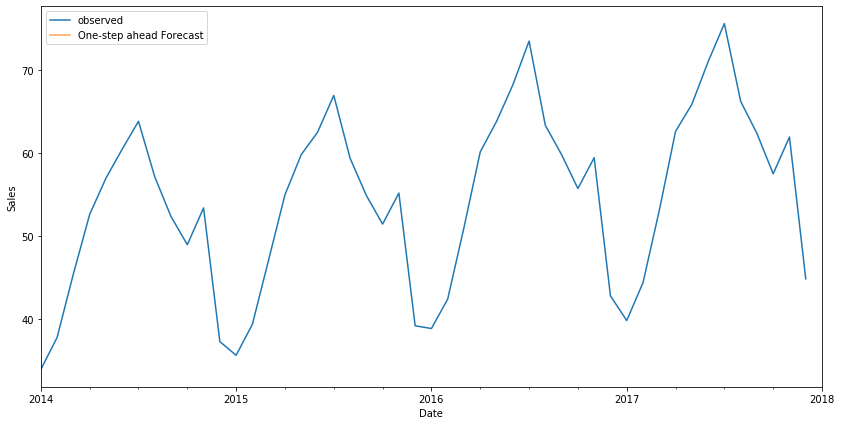

In [131]:
## Validating Forecast
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = train_monthly_sales['2014':].plot(label='observed')
pred.predicted_mean.plot(ax = ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [133]:
pred.predicted_mean

2018-01-01    43.629879
Freq: MS, dtype: float64

### Estimating and eliminating trend

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

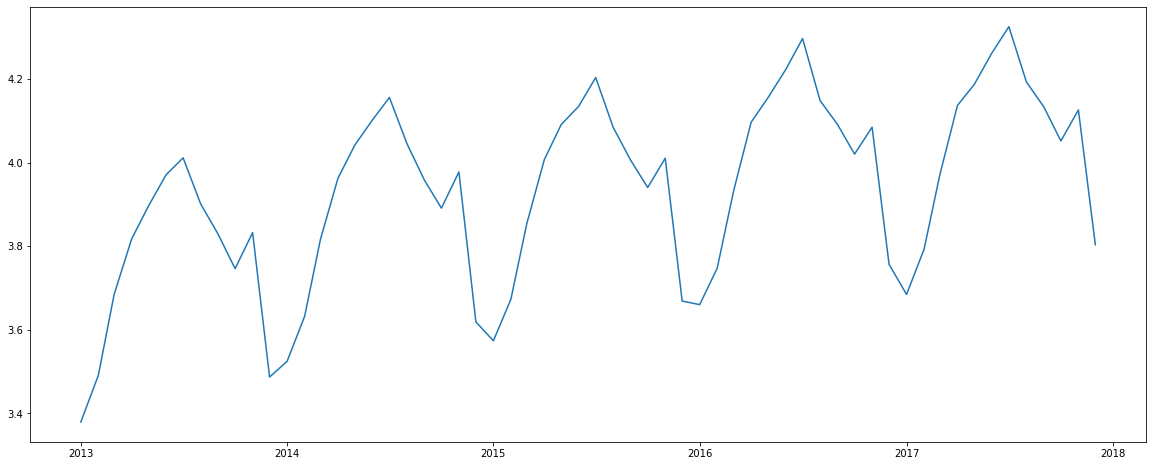

In [72]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [136]:
mod = sm.tsa.statespace.SARIMAX(train_monthly_sales, order=(2,1,2))
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                   60
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -192.357
Date:                Tue, 03 Nov 2020   AIC                            394.714
Time:                        00:17:56   BIC                            405.102
Sample:                    01-01-2013   HQIC                           398.769
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8686      0.476     -1.826      0.068      -1.801       0.064
ar.L2          0.1314      0.480      0.274      0.784      -0.810       1.073
ma.L1          1.2290      2.377      0.517      0.6

C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [137]:
train.store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [139]:
store1_sales = train.loc[train.store == 1]
store1_sales.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [141]:
store2_sales = train.loc[train.store == 2]
store2_sales.head()

,store,item,sales
date,,,
2013-01-01,2,1,12
2013-01-02,2,1,16
2013-01-03,2,1,16
2013-01-04,2,1,20
2013-01-05,2,1,16


In [143]:
store3_sales = train.loc[train.store == 3]
store4_sales = train.loc[train.store == 4]
store5_sales = train.loc[train.store == 5]
store6_sales = train.loc[train.store == 6]
store7_sales = train.loc[train.store == 7]
store8_sales = train.loc[train.store == 8]
store9_sales = train.loc[train.store == 9]
store10_sales = train.loc[train.store == 10]

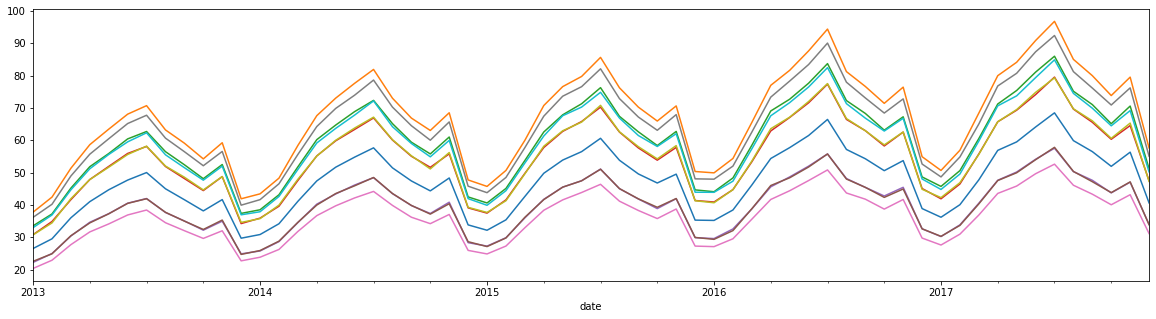

In [144]:
store1_monthly_sales = store1_sales.sales.resample('MS').mean()
store1_monthly_sales.plot(figsize = (20,5))

store2_monthly_sales = store2_sales.sales.resample('MS').mean()
store2_monthly_sales.plot(figsize = (20,5))

store3_monthly_sales = store3_sales.sales.resample('MS').mean()
store3_monthly_sales.plot(figsize = (20,5))

store4_monthly_sales = store4_sales.sales.resample('MS').mean()
store4_monthly_sales.plot(figsize = (20,5))

store5_monthly_sales = store5_sales.sales.resample('MS').mean()
store5_monthly_sales.plot(figsize = (20,5))

store6_monthly_sales = store6_sales.sales.resample('MS').mean()
store6_monthly_sales.plot(figsize = (20,5))

store7_monthly_sales = store7_sales.sales.resample('MS').mean()
store7_monthly_sales.plot(figsize = (20,5))

store8_monthly_sales = store8_sales.sales.resample('MS').mean()
store8_monthly_sales.plot(figsize = (20,5))

store9_monthly_sales = store9_sales.sales.resample('MS').mean()
store9_monthly_sales.plot(figsize = (20,5))

store10_monthly_sales = store10_sales.sales.resample('MS').mean()
store10_monthly_sales.plot(figsize = (20,5))

In [145]:
train.item.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [146]:
item1_sales = train.loc[train.item == 1]
item1_sales.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


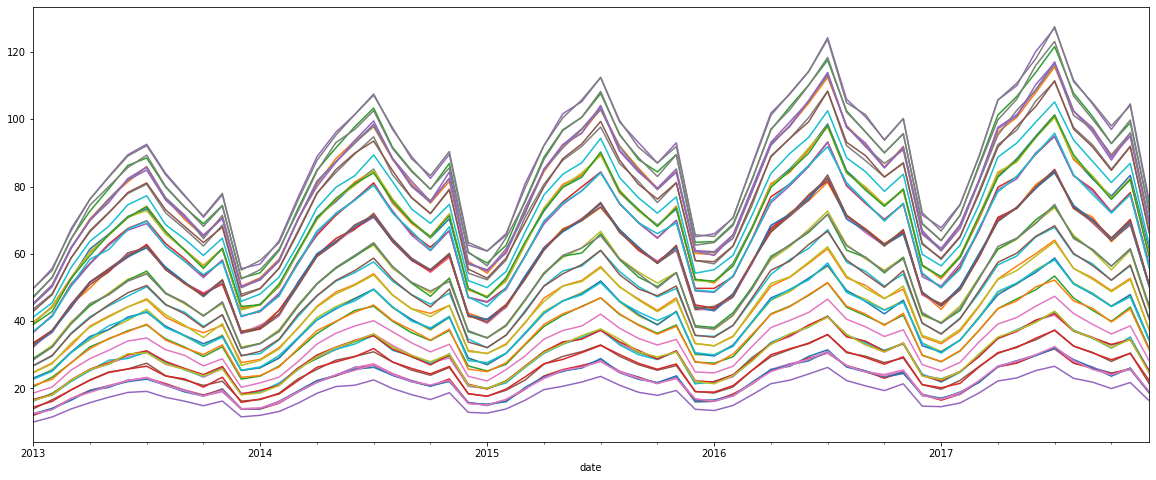

In [152]:
for x in train.item.unique():
    #str('item'+x+'_'+'sales') 
    filtered_data = train.loc[train.item == x]
    filtered_data.sales.resample('MS').mean().plot(figsize = (20,8))